In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from scipy.optimize import minimize
from tqdm import tqdm
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from cluster_local_new import ClusterLensing_fyp
from astropy.cosmology import FlatLambdaCDM
import pandas as pd

In [2]:
# inject data

scenarios = {
    '1': 'abell370',
    '2': 'abell2744',
    '3': 'abells1063',
    '4': 'macs0416',
    '5': 'macs0717',
    '6': 'macs1149'
}

full_cluster_names = {
    'abell370': 'Abell 370',
    'abell2744': 'Abell 2744',
    'abells1063': 'Abell S1063',
    'macs0416': 'MACS J0416.1-2403',
    'macs0717': 'MACS J0717.5+3745',
    'macs1149': 'MACS J1149.5+2223'
}

# Initialize lists to store the data arrays
datax_list = []
datay_list = []
data_psi_list = []

for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]

    file_dir = os.getcwd()
    fits_filex = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_x-arcsec-deflect.fits'
    )
    fits_filey = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_y-arcsec-deflect.fits'
    )
    psi_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/hlsp_frontier_model_{clustername}_williams_v4_psi.fits'
    )

    with fits.open(fits_filex) as hdulx, fits.open(fits_filey) as hduly, fits.open(psi_file) as hdul_psi:
        datax = hdulx[0].data 
        datay = hduly[0].data
        data_psi = hdul_psi[0].data

        # Append the data arrays to the lists
        datax_list.append(datax)
        datay_list.append(datay)
        data_psi_list.append(data_psi)

# Example: Access the first datax array
print(f"Length of the first datax array: {len(datax_list[1])}")


Length of the first datax array: 678


In [3]:
# getting the pixel scale list
def get_pixscale(cluster_name, file_path='GCdata/pixsize'):
    full_path = os.path.join(file_dir, file_path)
    with open(full_path, 'r', encoding='utf-8') as file:
        for line in file:
            if line.startswith(cluster_name):
                # Split the line to get the value after the colon and return it as a float
                return float(line.split(':')[1].strip())
    return None  # Return None if the cluster name isn't found

pixscale_list = []
for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]
    pixscale = get_pixscale(full_cluster_name)
    pixscale_list.append(pixscale)
print(pixscale_list)


[0.2, 0.25, 0.25, 0.2, 0.2, 0.2]


In [4]:
# set up the class
cluster = ClusterLensing_fyp(datax_list, datay_list, data_psi_list, 0.5, 1, pixscale_list, diff_z=False)


In [5]:
# check with the lenstronomy package directly
realsize = 678
grid = np.linspace(0, realsize-1, realsize)
grid = grid * 0.25

lens_model_list2 = ['INTERPOL']
kwargs_lens2 = [{'grid_interp_x': grid, 'grid_interp_y': grid, 'f_': data_psi_list[1]*0.25**2,
                          'f_x': datax_list[1], 'f_y': datay_list[1]}]
lensModel_real = LensModel(lens_model_list=lens_model_list2, z_source=1, z_lens=0.5)

# Use lens equation solver for verification
solver2 = LensEquationSolver(lensModel_real)
coord = (63.8, 84.1)
img_po = solver2.image_position_from_source(coord[0], coord[1], kwargs_lens2, min_distance=0.25, search_window=100, verbose=False, x_center=75, y_center=80)
print(img_po)



(array([25.04527574, 80.3895084 , 89.83823507, 70.3500693 , 62.87531747,
       63.56479705, 78.41485862]), array([96.30394225, 51.47812429, 71.45908221, 59.92729871, 45.81923451,
       52.27263524, 72.34180586]))


In [ ]:
# try mcmc for a known cluster


if __name__ == "__main__":
    # Suppose we have an instance 'fyp' of ClusterLensing_fyp
    # with x_center, y_center, etc. properly defined

    dt_obs = np.array([0,         63511.50255162, 74572.75220626, 74998.9896557, 80795.68574965])  # example time delays
    sampler, flat_samples = cluster.localize_mcmc_emcee(
        dt_true=dt_obs,
        index=5,
        n_walkers=32,
        n_steps=2000,
        burn_in=400,
        x_range=50.0,
        y_range=50.0,
        z_lower=2.5,
        z_upper=3.5,
        sigma=0.10,
        random_seed=233,
        n_processes=8
    )

    print("flat_samples shape =", flat_samples.shape)
    # For analysis:
    x_chain = flat_samples[:,0]
    y_chain = flat_samples[:,1]
    z_chain = flat_samples[:,2]
    print("Median:", np.median(x_chain), np.median(y_chain), np.median(z_chain))

    

In [ ]:
import corner

# Assuming sampler is your emcee sampler object and burn_in is defined.
# Retrieve the chain; shape: (n_steps, n_walkers, ndim)
chain = sampler.get_chain(flat=False)
n_steps, n_walkers, ndim = chain.shape
labels = ["x_src", "y_src", "z_s"]

# --- Plot Trace Plots ---
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    for walker in range(n_walkers):
        ax.plot(chain[:, walker, i], alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step Number")
plt.suptitle("Trace Plots for MCMC Parameters", fontsize=16)
plt.tight_layout()
plt.show()

# --- Plot Corner Plot ---
# Flatten the chain (each walker’s chain concatenated) after burn-in.
flat_samples = sampler.get_chain(flat=True)

figure = corner.corner(
    flat_samples,
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],
    truths=[80.1,99.9,3.3],  # Add true values for comparison
    smooth=1.0,  # Smooth out contours
    bins=30      # Increase the number of bins
)
plt.suptitle("Corner Plot of Posterior Distributions", fontsize=16)
plt.show()

In [ ]:
print("Acceptance fraction per walker:", sampler.acceptance_fraction)
print(sampler.get_autocorr_time())

In [7]:
# mcmc for fixed source redshift
if __name__ == "__main__":
    # Suppose we have an instance 'fyp' of ClusterLensing_fyp
    # with x_center, y_center, etc. properly defined

    dt_obs = np.array([0, 10876.86140717, 11637.33983443, 11645.14412352, 11827.21975328])  # example time delays
    sampler, flat_samples = cluster.localize_mcmc_emcee_fix_z(
        dt_true=dt_obs,
        index=1,
        n_walkers=16,
        n_steps=1200,
        burn_in=300,
        x_range=50.0,
        y_range=50.0,
        z_s_fix=3.0,
        sigma=0.10,
        random_seed=233,
        n_processes=8
    )

    print("flat_samples shape =", flat_samples.shape)
    # For analysis:
    x_chain = flat_samples[:,0]
    y_chain = flat_samples[:,1]
    print("Median:", np.median(x_chain), np.median(y_chain))

100%|██████████| 1200/1200 [1:22:30<00:00,  4.13s/it]

flat_samples shape = (14400, 2)
Median: 66.04628707985043 77.07293476193914


In [ ]:
# mixed mcmc and DE
dt_obs = np.array([0.0, 33646.486627627164, 38528.79597511212, 39567.651975078275, 40034.70956554217, 40239.1943321256, 40421.61809130898])  # your time delays

de_solution, mcmc_solution, sampler, samples = cluster.localize_diffevo_then_mcmc_known_cluster(
    dt_true=dt_obs,
    index=0,
    # DE settings
    early_stop=5e4,
    # MCMC settings
    n_walkers=21, n_steps=1500, burn_in=500,
                               x_range_prior=10.0, y_range_prior=10.0,
                               z_lower=2.5, z_upper=3.5,
                               sigma=0.10,
                               random_seed=42,
                               n_processes=8
)

print("DE solution:", de_solution)
print("MCMC median:", mcmc_solution)
print("samples shape:", samples.shape)

differential_evolution step 1: f(x)= 2800000000000.0
differential_evolution step 2: f(x)= 2800000000000.0
differential_evolution step 3: f(x)= 2800000000000.0
differential_evolution step 4: f(x)= 2851706269.958505
differential_evolution step 5: f(x)= 2851706269.958505
differential_evolution step 6: f(x)= 2851706269.958505
differential_evolution step 7: f(x)= 2851706269.958505
differential_evolution step 8: f(x)= 2851706269.958505
differential_evolution step 9: f(x)= 2851706269.958505
differential_evolution step 10: f(x)= 2851706269.958505
differential_evolution step 11: f(x)= 2851706269.958505
differential_evolution step 12: f(x)= 2851706269.958505
differential_evolution step 13: f(x)= 373545555.43452287
differential_evolution step 14: f(x)= 373545555.43452287
differential_evolution step 15: f(x)= 373545555.43452287
differential_evolution step 16: f(x)= 373545555.43452287
differential_evolution step 17: f(x)= 373545555.43452287
differential_evolution step 18: f(x)= 373545555.43452287
d

100%|██████████| 2000/2000 [3:15:02<00:00,  5.85s/it]  

MCMC median after DE: x=71.40, y=56.86, z=3.50
DE solution: (71.39980694242806, 57.00249328505116, 3.4901299363801965, 17687.774349414307)
MCMC median: (71.39996395105541, 56.8645082713229, 3.49985560651004)
samples shape: (31500, 3)


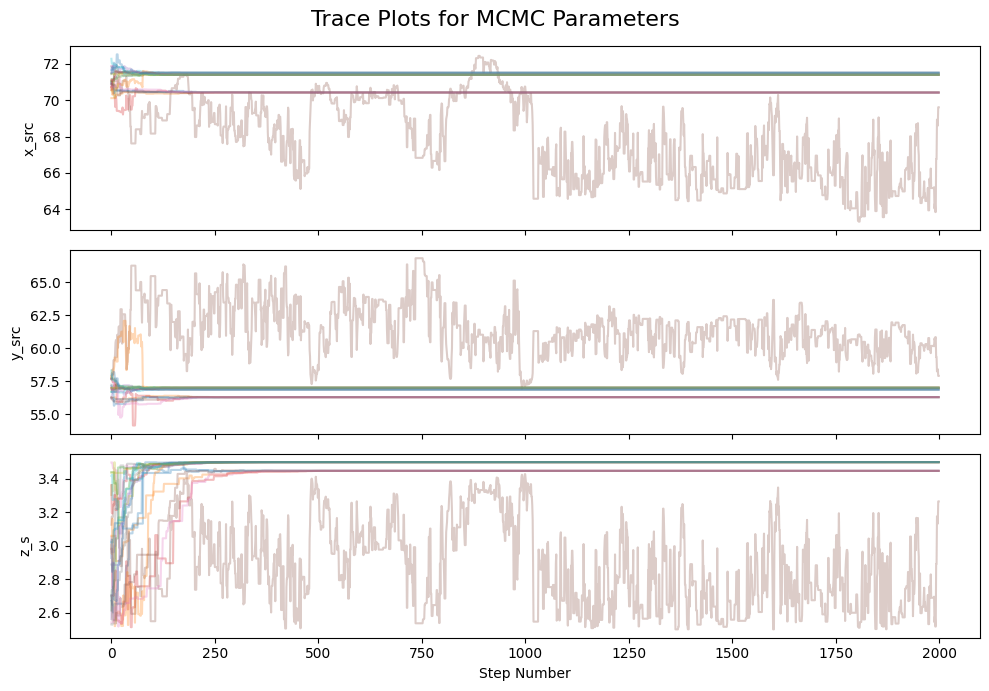

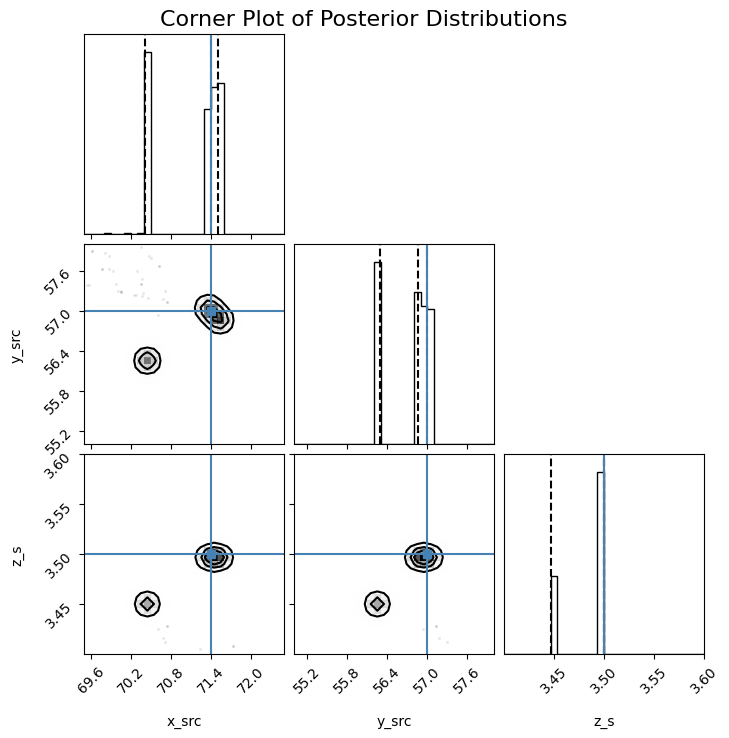

In [7]:
import corner

# Assuming sampler is your emcee sampler object and burn_in is defined.
# Retrieve the chain; shape: (n_steps, n_walkers, ndim)
chain = sampler.get_chain(flat=False)
n_steps, n_walkers, ndim = chain.shape
labels = ["x_src", "y_src", "z_s"]

# --- Plot Trace Plots ---
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    ax = axes[i]
    for walker in range(n_walkers):
        ax.plot(chain[:, walker, i], alpha=0.3)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step Number")
plt.suptitle("Trace Plots for MCMC Parameters", fontsize=16)
plt.tight_layout()
plt.show()

# --- Plot Corner Plot ---
# Flatten the chain (each walker’s chain concatenated) after burn-in.
flat_samples = sampler.get_chain(flat=True)

figure = corner.corner(
    samples,
    labels=labels,
    quantiles=[0.05, 0.5, 0.95],  # 90% interval
    truths=[71.4,57,3.5],  # Add true values for comparison
    range = [(69.5, 72.5), (55, 58), (3.4, 3.6)],
    smooth=1.0,  # Smooth out contours
    bins=30      # Increase the number of bins
)
plt.suptitle("Corner Plot of Posterior Distributions", fontsize=16)
plt.show()

In [14]:
chi_sq = cluster.chi_squared_with_z([71.50828753772272, 56.863915154564694, 3.499714369694242], dt_obs, index=3)
print("Chi-squared:", chi_sq)

Chi-squared: 24164.14594350057
